In [11]:
from collections import Counter
import spacy
import os
import glob
import xml.etree.ElementTree as et
import matplotlib.pyplot as plt
nlp = spacy.load("en_core_web_sm")

In [12]:
def calc(dir):
    
    spatial_entities = 0
    places = 0
    motions = 0
    qslinks = 0
    olinks = 0
    signals = 0
    values = []
    c_tokens = Counter()
    c_types = Counter()
    c_motion = Counter()
    c_qsl = Counter()
    c_ol = Counter()
    
    for file in os.listdir(dir):
        if file.endswith(".xml"):
            tree = et.parse(os.path.join(dir, file))
            root = tree.getroot()
            text = None
            for child in root:
                if child.tag == "TEXT":
                    doc = nlp(child.text)

                    # Wie oft kommen welche PoS-Tags vor?
                    c_t = Counter(([token.pos_ for token in doc]))
                    c_tokens = c_tokens + c_t

                    # Wie viele [SpatialEntities, Places, Motions, Signals, QsLinks, OLinks] gibt es?
                    c_se = Counter(([elem.tag for elem in root.iter("SPATIAL_ENTITY")]))
                    spatial_entities = spatial_entities + sum(c_se.values())

                    c_p = Counter(([elem.tag for elem in root.iter("PLACE")]))
                    places = places + sum(c_p.values())

                    c_m = Counter(([elem.tag for elem in root.iter("MOTION")]))
                    motions = motions + sum(c_m.values())

                    c_qs_link = Counter(([elem.tag for elem in root.iter("QSLINK")]))
                    qslinks = qslinks + sum(c_qs_link.values())

                    c_o_link = Counter(([elem.tag for elem in root.iter("OLINK")]))
                    olinks = olinks + sum(c_o_link.values())

                    # Signals = spatial signals + motion signals ?
                    c_s_s = Counter(([elem.tag for elem in root.iter("SPATIAL_SIGNAL")]))
                    c_m_s = Counter(([elem.tag for elem in root.iter("MOTION_SIGNAL")]))
                    c_s= sum(c_s_s.values()) + sum(c_m_s.values())
                    signals = signals + c_s

                    # Wie oft kommen welche QsLink Typen vor? (DC,EC, ...)?
                    c_qs_type =  Counter(([elem.get('relType') for elem in root.iter("QSLINK")]))
                    c_types = c_types + c_qs_type
                    
                    c_m =  Counter(([elem.get('text') for elem in root.iter("MOTION")]))
                    c_motion = c_motion + c_m
                    
                    # Welche Links (QSLINKS, OLINKS) werden von welchen Präpositionen (markiert durch SPATIAL_SIGNAL) getriggert?
                    triggers = []
                    for qslink in root.iter("QSLINK"):
                        if qslink.get("trigger") != "":
                            trigger = qslink.get("trigger"), qslink.get("id")
                            triggers.append(trigger)

                    for spatial_signal in root.iter("SPATIAL_SIGNAL"):
                        for i in range (len(triggers)):
                            if spatial_signal.get("id") in triggers[i]:
                                c_qsl.update([spatial_signal.get("text")])
                                
                    
                    triggers2 = []
                    for olink in root.iter("OLINK"):
                        if olink.get("trigger") != "":
                            trigger2 = olink.get("trigger"), olink.get("id")
                            triggers2.append(trigger2)

                    for spatial_signal in root.iter("SPATIAL_SIGNAL"):
                        for i in range (len(triggers2)):
                            if spatial_signal.get("id") in triggers2[i]:
                                c_ol.update([spatial_signal.get("text")])
                                
                    # Verteilung der Satzlänge graphisch darstellen (x: Satzlänge, y: Wie häufig)?
                    sentences = list(doc.sents)

                    # Häufigkeit von Sätzen 
                    for i in range(0, len(sentences)):
                        values.append(len(sentences[i]))

    return c_tokens, spatial_entities, places, motions, qslinks, olinks, signals, values, c_types, c_motion, c_qsl, c_ol

In [13]:
c_tokens1, spatial_entities1, places1, motions1, qslinks1, olinks1, signals1, values1, c_types1, c_motion1, c_qsl1, c_ol1 = calc("./Traning/CP")
c_tokens2, spatial_entities2, places2, motions2, qslinks2, olinks2, signals2, values2, c_types2, c_motion2, c_qsl2, c_ol2 = calc("./Traning/RFC")
c_tokens3, spatial_entities3, places3, motions3, qslinks3, olinks3, signals3, values3, c_types3, c_motion3, c_qsl3, c_ol3 = calc("./Traning/ANC/WhereToJapan")
c_tokens4, spatial_entities4, places4, motions4, qslinks4, olinks4, signals4, values4, c_types4, c_motion4, c_qsl4, c_ol4 = calc("./Traning/ANC/WhereToMadrid")

c_tokens = c_tokens1 + c_tokens2 + c_tokens3 + c_tokens4
spatial_entities = spatial_entities1 + spatial_entities2 + spatial_entities3 + spatial_entities4
places = places1 + places2 + places3 + places4
motions = motions1 + motions2 + motions3 + motions4
qslinks = qslinks1 + qslinks2 + qslinks3 + qslinks4
olinks = olinks1 + olinks2 + olinks3 + olinks4
signals = signals1 + signals2 + signals3 + signals4
values = values1 + values2 + values3 + values4
c_types = c_types1 + c_types2 + c_types3 + c_types4
c_motion = c_motion1 + c_motion2 + c_motion3 + c_motion4
c_qsl = c_qsl1 + c_qsl2 + c_qsl3 + c_qsl4
c_ol = c_ol1 + c_ol2 + c_ol3 + c_ol4

In [14]:
# Print Antworten
# for tag, count in c_tokens.items():
#     print(tag, "=", count)
# print("Es gibt =" , spatial_entities, "Spatial Entities")
# print("Es gibt =" , places , "Places")
# print("Es gibt =" , motions, "Motions")
# print("Es gibt =" , signals, "Signals")
# print("Es gibt =" , qslinks, "QsLinks")
# print("Es gibt =" , olinks, "OLinks")
# for typ, count in c_types.items():
#     print(typ, "=", count)
# for motions, count in c_motion.most_common(5):
#     print(motions, count, sep=': ')
# for signal, count in c_qsl.items():
#     print("QSLINK wurde", count, "mal von", signal, "getirggert")
# for signal, count in c_ol.items():
#     print("OLink wurde", count, "mal von", signal, "getirggert")

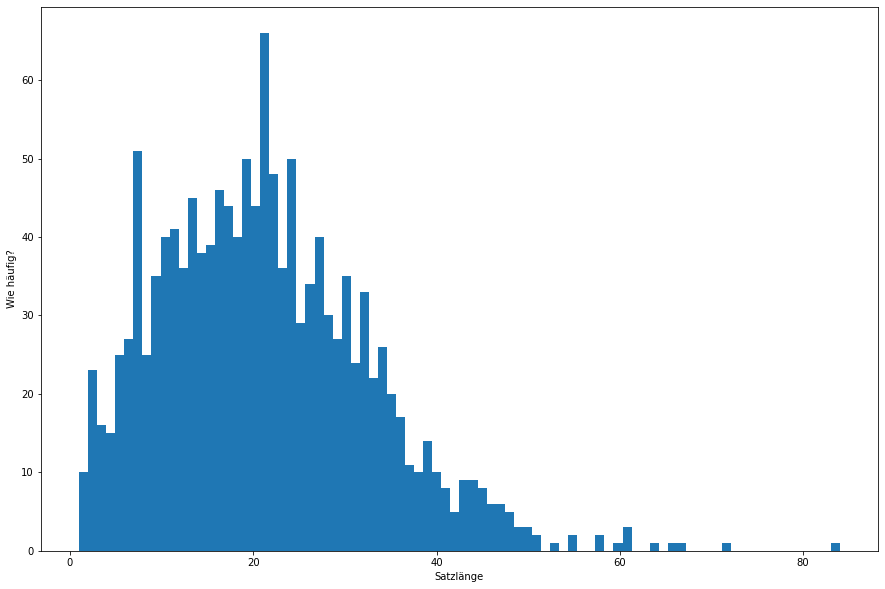

In [15]:
plt.hist(values, bins = max(values))

# Titel und Axis-Namen
plt.xlabel('Satzlänge')
plt.ylabel('Wie häufig?')

plt.show()

In [16]:
import networkx as nx
%matplotlib inline

In [17]:
# ich hoffe so was wurde gemeint bei dieser Übung
def vis(dir, save):
    tree = et.parse(dir)
    root = tree.getroot()
    G=nx.Graph()

    ids = []
    labeldict= {}
    for elem in root.iter("PLACE"):
        ids.append(elem.get("id"))
    #     G.add_node(elem.get("text"))

    for elem in root.iter("SPATIAL_ENTITY"):
        ids.append(elem.get("id"))
    #     G.add_node(elem.get("text"))
    
    labeldict= {}
    for elem in root.iter("METALINK"):
        if elem.get("fromID") in ids:
            if elem.get("toID") in ids:
                G.add_node(elem.get("toText"))
                labeldict[elem.get("toText")]= elem.get("toText")
            

    for elem in root.iter("QSLINK"):
        if elem.get("fromID") in ids:
            if elem.get("toID") in ids:
                G.add_edge(elem.get("fromText"), elem.get("toText"))
                labeldict[elem.get("toText")]= elem.get("relType")
            
    for elem in root.iter("OLINK"):
        if elem.get("fromID") in ids:
            if elem.get("toID") in ids:
                G.add_edge(elem.get("fromText"), elem.get("toText"))
                labeldict[elem.get("toText")]= elem.get("relType")
    
    nx.draw(G, labels =labeldict, with_labels = True)
    plt.rcParams['figure.figsize'] = [15, 10]
    plt.savefig(save)
    plt.show()

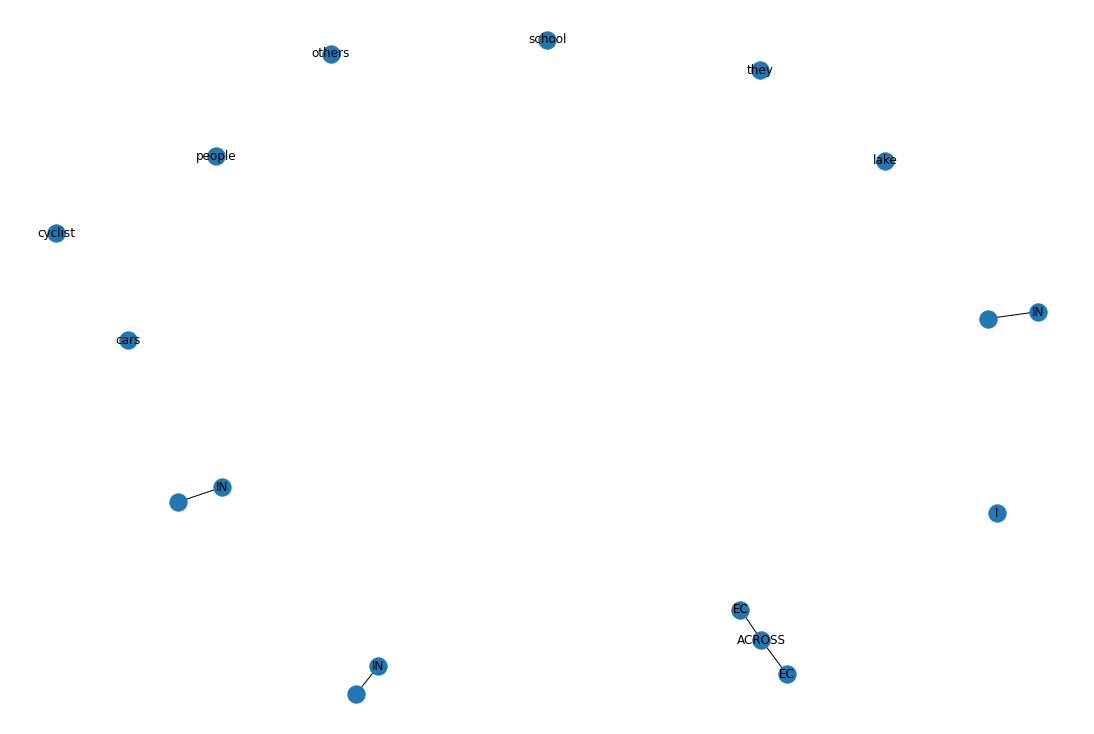

In [20]:
vis("./Traning/RFC/Bicycles.xml", "bicylces_graph.png")

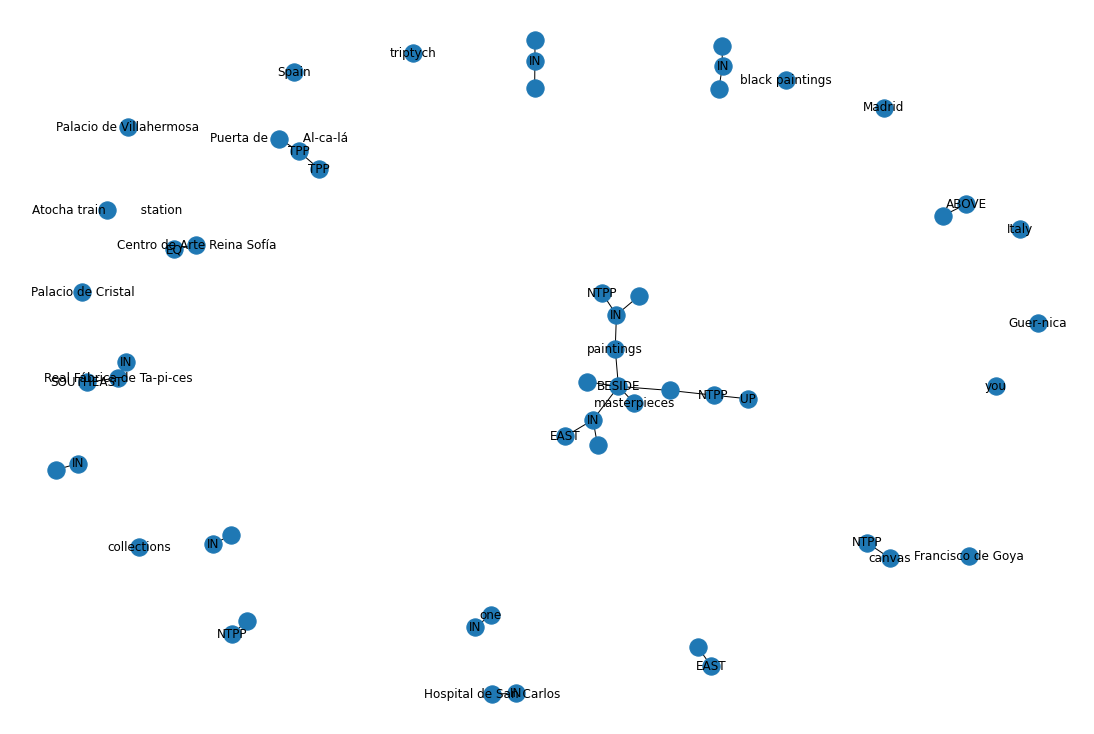

In [21]:
vis("./Traning/ANC/WhereToMadrid/Highlights_of_the_Prado_Museum.xml", "Highlights_of_the_Prado_Museum_graph.png")